In [16]:
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
# import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [17]:

sc.set_figure_params(facecolor="white", figsize=(8, 8), dpi_save=300)
sc.settings.verbosity = 1
sc.settings.figdir = './figures-visium/'

In [18]:
path = '/nfs/team292/lg18/gonads/data/visium/'

# sample IDs
SCsamples = {'F83':["FCA_GNDST8796125", "FCA_GNDST8796126"], 
           'F91':["FCA_GNDST8796127", "FCA_GNDST8796128"],
           'F94':["FCA_GNDST8796129", "FCA_GNDST8796130"],
           'Hrv11':["FCA_GNDST8796131", "FCA_GNDST8796132"],
           'F81':['FCA_GNDST9421027'],
            'Hrv41':['FCA_GNDST9421026']
            }

Vsamples = {'F91':["FCA_GNDST8796127", "FCA_GNDST8796128"],
           'Hrv11':["FCA_GNDST8796131", "FCA_GNDST8796132"],
           'F83':["FCA_GNDST8796125", "FCA_GNDST8796126"], 
           'F94':["FCA_GNDST8796129", "FCA_GNDST8796130"],
           'F81':['FCA_GNDST9421027'],
           'Hrv41':['FCA_GNDST9421026'],
            'females':["FCA_GNDST8796125", "FCA_GNDST8796126", 
                       "FCA_GNDST8796127", "FCA_GNDST8796128", 
                       "FCA_GNDST8796131", "FCA_GNDST8796132"],
            'males':["FCA_GNDST8796129", "FCA_GNDST8796130", 'FCA_GNDST9421026']
           }
            

# Reading Visium data


The function read_visium returns an AnnData object that contains counts, images and spatial coordinates. We will calculate standards QC metrics with pp.calculate_qc_metrics and visualize them.

An anndata will be saved for cell2location.


In [19]:
def read_and_qc(sample_name, path):

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.obs['sample'] = sample_name
    adata.var['SYMBOL'] = adata.var_names
    adata.var.rename(columns={'gene_ids': 'ENSEMBL'}, inplace=True)
    adata.var_names = adata.var['ENSEMBL']
    adata.var.drop(columns='ENSEMBL', inplace=True)

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('mt-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # mitochondria-encoded (MT) genes should be removed for spatial mapping
    adata.obsm['mt'] = adata[:, adata.var['mt'].values].X.toarray()
    adata = adata[:, ~adata.var['mt'].values]

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata


def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [20]:
for sam in Vsamples.keys():
    # read first sample
    adata = read_and_qc(Vsamples[sam][0], path=path)

    # read the remaining samples
    slides = {}
    for i in Vsamples[sam][1:]:
        adata_1 = read_and_qc(i, path=path)
        slides[str(i)] = adata_1

    adata_0 = adata.copy()

    # combine individual samples
    adata = adata.concatenate(
        list(slides.values()),
        batch_key="sample",
        uns_merge="unique",
        batch_categories=Vsamples[sam],
        index_unique=None
    )
    # merging metadata
    adata.obs['sample_name'] = sam

    
    os.system('mkdir -p '+ path+'/cell2location/'+ sam +'/')  
    adata.write(path + '/cell2location/' + sam + '/'+ sam + '_visium.h5ad')
      

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
... storing 'sample_name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'SYMBOL' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.obs` of view, copying.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Trying to set attribute `.ob

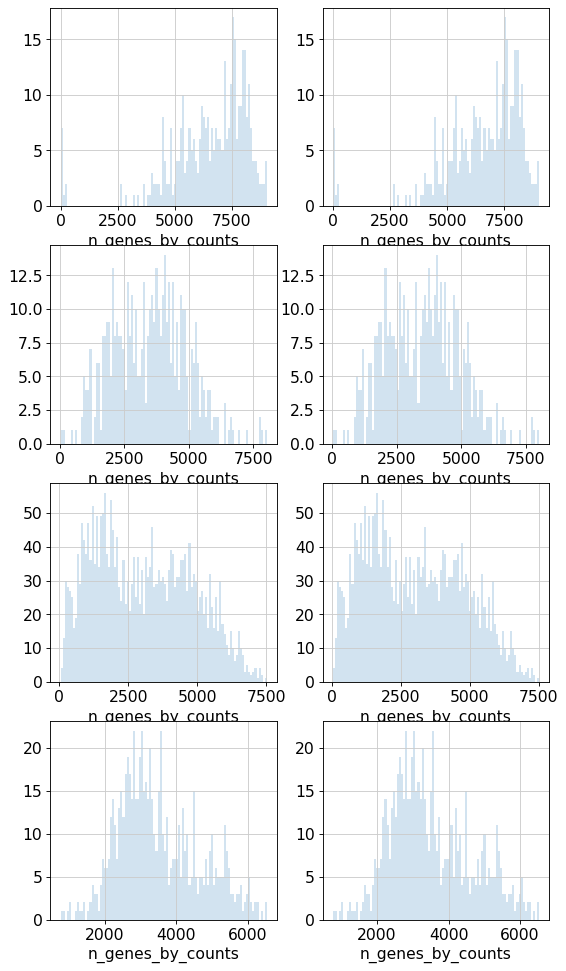

In [21]:
VsamplesPaper  = {'F91':["FCA_GNDST8796127", "FCA_GNDST8796128"],
           'Hrv11':["FCA_GNDST8796131", "FCA_GNDST8796132"],
           'F83':["FCA_GNDST8796125", "FCA_GNDST8796126"], 
           'F94':["FCA_GNDST8796129", "FCA_GNDST8796130"]}


fig, axs = plt.subplots(4, 2, figsize=(8, 15))

j = 0
for sam in VsamplesPaper.keys():
    i = 0
    for sli in Vsamples[sam]:
        spt_adata =  read_and_qc(Vsamples[sam][0], path=path)
        sns.distplot(spt_adata.obs["n_genes_by_counts"], kde=False, bins=100, hist_kws={"alpha": 0.2}, ax=axs[j][i])
        i = i + 1
    j = j + 1
      

# Reading the merged scRNA dataset


In [22]:
adata = sc.read('/nfs/team292/lg18/with_valentina/FCA-M5-annotatedCluster4Seurat.h5ad')
adata.X.shape

(319081, 28230)

In [23]:
# Add cluster name and doublet information
clu_annot = pd.read_csv('figures_manual_annotation/clustering_metadata.csv', header=0, index_col=0)
import collections 

if collections.Counter(adata.obs.index) == collections.Counter(clu_annot.index): 
    print ("The lists are identical") 
else : 
    print ("The lists are not identical") 
    
vars2import = ['clusters_manual','louvain', 'is_doublet', 'scrublet_cluster_score', 'scrublet_score']
for var in vars2import:
    adata.obs[var] = clu_annot[var]

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (24,25,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The lists are identical


In [24]:
# Increase female 8 PCWs coverage
adata.obs[ 'individual'][ np.array(adata.obs[ 'individual'] == 'F89')] = 'F81'
adata.obs[ 'individual'][ np.array(adata.obs[ 'individual'] == 'F99')] = 'F81'
adata.obs[ 'individual'][ np.array(adata.obs[ 'individual'] == 'Hrv12')] = 'F81'
adata.obs[ 'individual'][ np.array(adata.obs[ 'individual'] == 'Hrv47')] = 'F81'

# Increase male 9 PCWs coverage
adata.obs[ 'individual'][ np.array(adata.obs[ 'individual'] == 'Hrv31')] = 'Hrv41'

# Increase female 11 PCWs coverage
adata.obs[ 'individual'][ np.array(adata.obs[ 'individual'] == 'F87')] = 'F91'
adata.obs[ 'individual'][ np.array(adata.obs[ 'individual'] == 'Hrv30')] = 'F91'

# Increase female 14 PCWs coverage
adata.obs[ 'individual'][ np.array(adata.obs[ 'individual'] == 'F96')] = 'Hrv11'
adata.obs[ 'individual'][ np.array(adata.obs[ 'individual'] == 'Hrv39')] = 'Hrv11'

# Increase male 12 PCWs coverage
adata.obs[ 'individual'] = adata.obs[ 'individual'].cat.add_categories(['F94'])
adata.obs[ 'individual'][ np.array(adata.obs[ 'individual'] == 'Hrv18')] = 'F94'
adata.obs[ 'individual'][ np.array(adata.obs[ 'individual'] == 'Hrv32')] = 'F94'

# Increase female 17 PCWs coverage
adata.obs[ 'individual'][ np.array(adata.obs[ 'individual'] == 'F133')] = 'F83'

### Add cell type annotations from subanalysis as LABELS

In [25]:
## Add cell type annotations as LABELS
adata.obs['labels'] = adata.obs['clusters_manual'].tolist() 

# Load SOMATIC and GERM cells gonads
germcells = pd.read_csv('/nfs/team292/lg18/with_valentina/germcells_annotation.csv', index_col = 0)
suppcells = pd.read_csv('/nfs/team292/lg18/with_valentina/supporting_nocycling_annotation.csv', index_col = 0)
mecells = pd.read_csv('/nfs/team292/lg18/with_valentina/mesenchymal_annotated.csv', index_col = 0)

# Get dictionary and map
mydic = germcells
mydic = mydic.append(suppcells)
mydic = mydic.append(mecells)

mapping_dict = mydic['annotated_clusters'].to_dict()
adata.obs['labels'] = adata.obs_names.map(mapping_dict)
adata.obs['labels'].value_counts(dropna = False)


# Replace NaN with big clusters 
adata.obs['labels'] = adata.obs['labels'].fillna(adata.obs['clusters_manual'])
adata.obs['labels'].value_counts(dropna = False)


Sertoli                    27701
M_MGP                      26162
Ti                         24745
lowQC                      20815
M_cycling                  16376
Gi                         14846
Supporting_female          12471
Oi                         11900
preGC_I_OSR1               11714
Endothelial                10948
Epithelial                  9679
Sertoli_low                 8763
preGC_II_hypoxia            8180
preGC_III                   7871
PV                          7440
Erythroid                   7423
Mesenchymal_LHX9_ARX        7144
M_MullDuct_LGR5             6811
preGC_II                    6669
Mesenchymal_GATA2_NR2F1     5995
Doublets                    5639
Immune                      5157
ovarianSurf                 5148
M_prog_ISL1                 5021
M_ALX1                      4625
coelEpi                     4385
M_MullDuct_AMHR2            3318
Coel Epi                    3070
sLGR5                       2660
Neural                      2530
Germ cells

In [26]:
## Remove general cycling
adata = adata[[ 'cycling' not in i for i in adata.obs.labels]]
adata = adata[[ 'oublet' not in i for i in adata.obs.labels]]
adata = adata[[ 'lowQC' not in i for i in adata.obs.labels]]
adata = adata[[ 'cont' not in i for i in adata.obs.labels]]
adata = adata[[ i not in ['FetalLeydig-like', 'Supporting_female', 'Erythroid', 
                          'Mesenchymal_LHX9_ARX', 'Mesenchymal_GATA2_NR2F1', 
                          'Neural', 'Germ cells', 'Coel Epi', 'Metanephros',
                         'Sertoli_low'] for i in adata.obs.labels]]
set(adata.obs.labels)
adata.obs.labels.value_counts()

Sertoli              27701
M_MGP                26162
Ti                   24745
Gi                   14846
Oi                   11900
preGC_I_OSR1         11714
Endothelial          10948
Epithelial            9679
preGC_II_hypoxia      8180
preGC_III             7871
PV                    7440
M_MullDuct_LGR5       6811
preGC_II              6669
Immune                5157
ovarianSurf           5148
M_prog_ISL1           5021
M_ALX1                4625
coelEpi               4385
M_MullDuct_AMHR2      3318
sLGR5                 2660
preGC_III_Notch       2409
FetalLeydig           2368
PGC                   2011
oogonia_meiosis       1852
sPAX8b                1783
oogonia_STRA8         1672
sPAX8m                1645
sKITLG                1245
Sertoli_WFDC2         1074
oocyte                 919
PGC_mitotic            869
GC_mitotic             793
pre-spermatogonia      753
Name: labels, dtype: int64

### Use Ensembl id as GENE 

In [27]:
adata.var['SYMBOL'] = adata.var_names
adata.var.rename(columns={'gene_ids-0': 'ENSEMBL'}, inplace=True)
adata.var_names = adata.var['ENSEMBL']
adata.var.drop(columns='ENSEMBL', inplace=True)

Trying to set attribute `.var` of view, copying.


### Slice dataset per individual

F83


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
Endothelial          536
GC_mitotic           497
Gi                   519
Immune               146
M_MGP               1196
Oi                  1756
PGC                  711
PGC_mitotic          234
PV                   455
coelEpi               92
oocyte               578
oogonia_STRA8       1114
oogonia_meiosis     1165
ovarianSurf         1828
preGC_II            1707
preGC_III           3370
preGC_III_Notch     1177
preGC_II_hypoxia    2570
preGC_I_OSR1         641
dtype: int64
F91


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
Endothelial          325
Epithelial           297
GC_mitotic            76
Gi                   386
Immune                57
M_ALX1               113
M_MGP               1427
M_MullDuct_AMHR2     291
M_MullDuct_LGR5      401
M_prog_ISL1           36
Oi                  1323
PGC                   24
PGC_mitotic            5
PV                   218
coelEpi              140
oogonia_STRA8        219
oogonia_meiosis       50
ovarianSurf          757
preGC_II            1438
preGC_II_hypoxia    1946
preGC_I_OSR1        1486
sKITLG                21
sLGR5                 27
sPAX8b                78
dtype: int64
F94


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
Endothelial           674
Epithelial            186
FetalLeydig           260
Gi                   1138
Immune                838
M_ALX1                106
M_MGP                2806
M_MullDuct_AMHR2       69
M_MullDuct_LGR5        18
PGC                    35
PV                    358
Sertoli              6104
Sertoli_WFDC2          84
Ti                   1518
coelEpi                80
pre-spermatogonia       9
sPAX8m                255
dtype: int64
Hrv11


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
Endothelial          429
Epithelial           303
GC_mitotic            10
Gi                   448
Immune                93
M_ALX1                20
M_MGP               1483
M_MullDuct_AMHR2      39
M_MullDuct_LGR5      424
M_prog_ISL1           19
Oi                   702
PGC                   61
PV                   222
coelEpi              150
oocyte                26
oogonia_STRA8         38
oogonia_meiosis      102
ovarianSurf          258
preGC_II             344
preGC_III            374
preGC_II_hypoxia     164
preGC_I_OSR1         217
sPAX8b                17
dtype: int64
F81


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
Endothelial          424
Epithelial           507
Gi                   611
Immune               146
M_ALX1              1212
M_MGP                790
M_MullDuct_AMHR2    1424
M_MullDuct_LGR5      221
M_prog_ISL1         2639
Oi                  1597
PGC                   22
PGC_mitotic            5
PV                   245
coelEpi              685
ovarianSurf          425
preGC_II            1123
preGC_II_hypoxia    1114
preGC_I_OSR1        2895
sKITLG               655
sLGR5               1341
sPAX8b               805
dtype: int64
Hrv41


/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
Endothelial         548
Epithelial          636
FetalLeydig         172
Gi                  955
Immune              410
M_ALX1              668
M_MGP               780
M_MullDuct_AMHR2    422
M_MullDuct_LGR5      56
M_prog_ISL1          36
PGC                   8
PV                  158
Sertoli             746
Sertoli_WFDC2        49
Ti                  426
coelEpi             808
sPAX8b              227
sPAX8m              133
dtype: int64


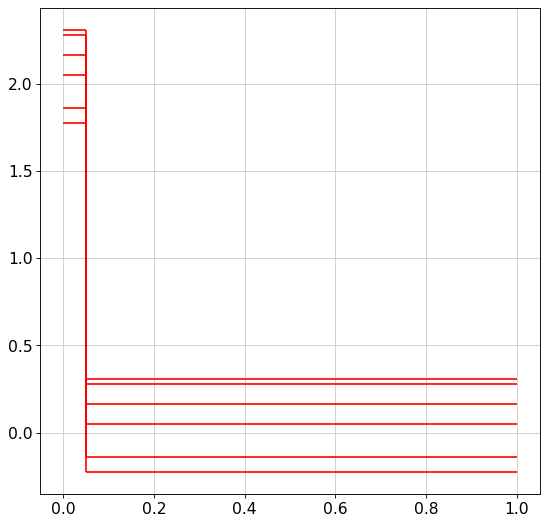

In [28]:
germ_cells = ['PGC', 'PGC_mitotic',  'GC_mitotic',  'oogonia_STRA8',  'oogonia_meiotic',  'oocyte', 'pre-spermatogonia']
male_cl = ['Ti', 'pre-spermatogonia', 'FetalLeydig', 'Sertoli', 'Sertoli_WFDC2', 'sPAX8m']
female_cl = ['Oi',  'oogonia_STRA8',  'oogonia_meiotic',  'oocyte', 'preGC_I_OSR1', 'preGC_II', 'preGC_II_hypoxia', 'preGC_III', 'preGC_III_Notch', 'ovarianSurf']

for sam in SCsamples.keys():
    print(sam)
    andata_f = adata[[ind in sam for ind in adata.obs['individual']]]
    freqs = andata_f.obs.groupby('labels').size()
    # keep labels more than 5 cells
#     if 'Hrv11' in sam:
#         andata_f = andata_f[[i  in freqs[ freqs > 6].index for i in andata_f.obs.labels ]]
#     else:
    andata_f = andata_f[[i in freqs[ freqs > 3 ].index for i in andata_f.obs.labels ]] 
    andata_f = andata_f[[i in freqs[ freqs > 15 ].index or i in germ_cells for i in andata_f.obs.labels ]]        
       
    # F83 does not have any epithelial duct, from visual inspection of the H&E
    if 'F83' in sam:
        andata_f = andata_f[[ i not in ['M_MullDuct_AMHR2', 'M_MullDuct_LGR5', 'M_prog_ISL1', 'M_CRABP1_BMP4', 'Epithelial']  for i in andata_f.obs.labels ]] 
        andata_f = andata_f[[ i not in male_cl  for i in andata_f.obs.labels ]]  
    if 'F91' in sam:
        andata_f = andata_f[[ i not in ['preGC_III', 'preGC_III_Notch']  for i in andata_f.obs.labels ]]
        andata_f = andata_f[[ i not in male_cl  for i in andata_f.obs.labels ]]  
    if 'Hrv11' in sam:
        andata_f = andata_f[[ i not in ['preGC_III_Notch']  for i in andata_f.obs.labels ]]
        andata_f = andata_f[[ i not in male_cl  for i in andata_f.obs.labels ]]  
    if 'F81' in sam:
        andata_f = andata_f[[ i not in ['preGC_III_Notch', 'preGC_III']  for i in andata_f.obs.labels ]]
        andata_f = andata_f[[ i not in male_cl  for i in andata_f.obs.labels ]]   
    if 'F94' in sam:
        andata_f = andata_f[[ i not in female_cl  for i in andata_f.obs.labels ]]  
    if 'Hrv41' in sam:
        andata_f = andata_f[[ i not in female_cl  for i in andata_f.obs.labels ]]   
# Reduce the number of genes by discarding lowly expressed genes
# This is performed using 2 cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG):
# - Include all genes expressed by at least 1% of cells (cell_count_cutoff2)
# - BECAUSE WE HAVE VERY RARE CELL TYPES (germ cells) Include genes expressed by at least 0.01% of cells (cell_count_cutoff) 
#   when they have high counts in non-zero cells (nonz_mean_cutoff)

    # Remove cells and genes with 0 counts everywhere
    sc.pp.filter_cells(andata_f, min_genes=2)
    sc.pp.filter_genes(andata_f, min_cells=2)

    # calculate the mean of each gene across non-zero cells
    andata_f.var['n_cells'] = (andata_f.X.toarray() > 0).sum(0)
    andata_f.var['nonz_mean'] = andata_f.X.toarray().sum(0) / andata_f.var['n_cells']
    nonz_mean_cutoff = 0.05
    cell_count_cutoff = np.log10(andata_f.shape[0] * 0.0001)
    cell_count_cutoff2 = np.log10(andata_f.shape[0] * 0.01)
    plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color='red');
    plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color='red');
    plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color='red');

    # select genes based on mean expression in non-zero cells
    andata_ff = andata_f[:,(np.array(np.log10(andata_f.var['nonz_mean']) > nonz_mean_cutoff)
                            | np.array(np.log10(andata_f.var['n_cells']) > cell_count_cutoff2))
                             & np.array(np.log10(andata_f.var['n_cells']) > cell_count_cutoff)
                             & np.array(~andata_f.var.index.isna())]

    os.system('mkdir -p '+ path+'/cell2location/'+sam+'/')  
    andata_ff.write(path + '/cell2location/' + sam + '/'+ sam + '_scRNAseq.h5ad')
    
    freqs = andata_ff.obs.groupby('labels').size()
    print(freqs)

# Slice dataset for females

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
Endothelial         1290
Epithelial           713
GC_mitotic           583
Gi                  1353
Immune               296
M_ALX1               137
M_MGP               4106
M_MullDuct_AMHR2     333
M_MullDuct_LGR5      857
M_prog_ISL1           59
Oi                  3781
PGC                  796
PGC_mitotic          242
PV                   895
coelEpi              382
oocyte               606
oogonia_STRA8       1371
oogonia_meiosis     1317
ovarianSurf         2843
preGC_II            3489
preGC_III           5829
preGC_III_Notch     1642
preGC_II_hypoxia    4680
preGC_I_OSR1        2344
sPAX8b               102
dtype: int64


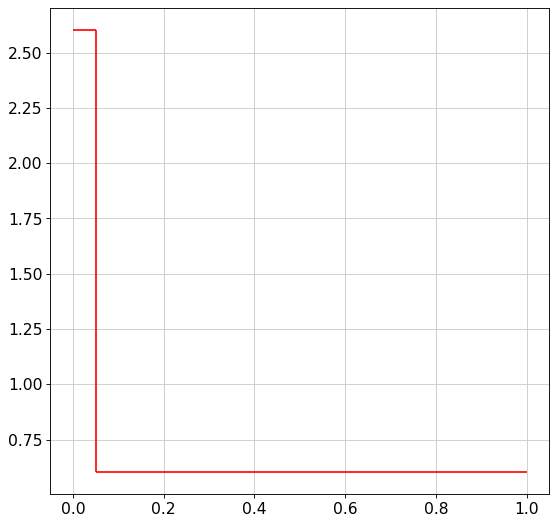

In [29]:
germ_cells = ['PGC', 'PGC_mitotic',  'GC_mitotic',  'oogonia_STRA8',  'oogonia_meiotic',  'oocyte', 'gonocyte']
sam = ['F83', 'F91', 'Hrv11']
andata_f = adata[[ind in sam for ind in adata.obs['individual']]]
freqs = andata_f.obs.groupby('labels').size()
andata_f = andata_f[[i in freqs[ freqs > 50 ].index for i in andata_f.obs.labels ]] 
andata_f = andata_f[[i in freqs[ freqs > 40 ].index or i in germ_cells for i in andata_f.obs.labels ]]        


# Remove male clusters
andata_f = andata_f[[ i not in male_cl  for i in andata_f.obs.labels ]]  
# Reduce the number of genes by discarding lowly expressed genes
# This is performed using 2 cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG):
# - Include all genes expressed by at least 1% of cells (cell_count_cutoff2)
# - BECAUSE WE HAVE VERY RARE CELL TYPES (germ cells) Include genes expressed by at least 0.01% of cells (cell_count_cutoff) 
#   when they have high counts in non-zero cells (nonz_mean_cutoff)

# Remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(andata_f, min_genes=2)
sc.pp.filter_genes(andata_f, min_cells=2)

# calculate the mean of each gene across non-zero cells
andata_f.var['n_cells'] = (andata_f.X.toarray() > 0).sum(0)
andata_f.var['nonz_mean'] = andata_f.X.toarray().sum(0) / andata_f.var['n_cells']
# plt.hist2d(np.log10(andata_f.var['nonz_mean']),
#            np.log10(andata_f.var['n_cells']), bins=100,
#            norm=mpl.colors.LogNorm(),
#            range=[[0,0.5], [1,4.5]]);
nonz_mean_cutoff = 0.05
cell_count_cutoff = np.log10(andata_f.shape[0] * 0.0001)
cell_count_cutoff2 = np.log10(andata_f.shape[0] * 0.01)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color='red');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color='red');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color='red');

# select genes based on mean expression in non-zero cells
andata_ff = andata_f[:,(np.array(np.log10(andata_f.var['nonz_mean']) > nonz_mean_cutoff)
                        | np.array(np.log10(andata_f.var['n_cells']) > cell_count_cutoff2))
                         & np.array(np.log10(andata_f.var['n_cells']) > cell_count_cutoff)
                         & np.array(~andata_f.var.index.isna())]

os.system('mkdir -p '+ path+'/cell2location/females/')  
andata_ff.write(path + '/cell2location/females/females_scRNAseq.h5ad')

freqs = andata_ff.obs.groupby('labels').size()
print(freqs)

# Slice dataset for males

/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/jovyan/my-conda-envs/cellpymc/lib/python3.7/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variab

labels
Endothelial         1222
Epithelial           822
FetalLeydig          432
Gi                  2093
Immune              1248
M_ALX1               774
M_MGP               3586
M_MullDuct_AMHR2     491
M_MullDuct_LGR5       74
M_prog_ISL1           44
PGC                   43
PV                   516
Sertoli             6850
Sertoli_WFDC2        133
Ti                  1944
coelEpi              888
sPAX8b               233
sPAX8m               388
dtype: int64


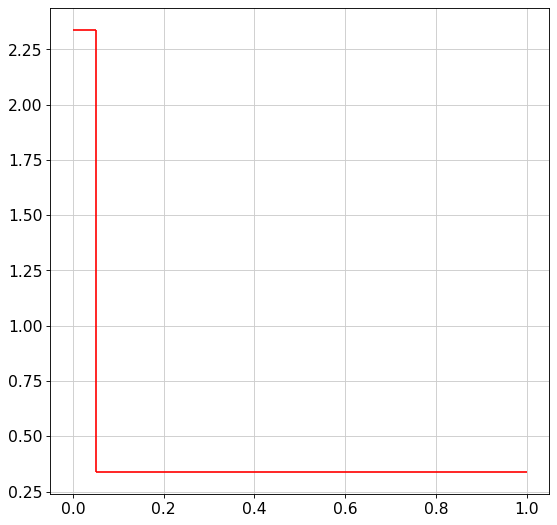

In [30]:
germ_cells = ['sLGR5', 'PGC', 'PGC_mitotic',  'GC_mitotic',  'oogonia_STRA8',  'oogonia_meiotic',  'oocyte', 'gonocyte']
sam = ['F94', 'Hrv41']
andata_f = adata[[ind in sam for ind in adata.obs['individual']]]
freqs = andata_f.obs.groupby('labels').size()
andata_f = andata_f[[i in freqs[ freqs > 5 ].index for i in andata_f.obs.labels ]] 
andata_f = andata_f[[i in freqs[ freqs > 30 ].index or i in germ_cells for i in andata_f.obs.labels ]]        


# Remove female clusters
andata_f = andata_f[[ i not in female_cl  for i in andata_f.obs.labels ]] # Reduce the number of genes by discarding lowly expressed genes
# This is performed using 2 cut-off to remove as many lowly expressed genes as possible and yet avoid highly variable gene selection (HVG):
# - Include all genes expressed by at least 1% of cells (cell_count_cutoff2)
# - BECAUSE WE HAVE VERY RARE CELL TYPES (germ cells) Include genes expressed by at least 0.01% of cells (cell_count_cutoff) 
#   when they have high counts in non-zero cells (nonz_mean_cutoff)

# Remove cells and genes with 0 counts everywhere
sc.pp.filter_cells(andata_f, min_genes=2)
sc.pp.filter_genes(andata_f, min_cells=2)

# calculate the mean of each gene across non-zero cells
andata_f.var['n_cells'] = (andata_f.X.toarray() > 0).sum(0)
andata_f.var['nonz_mean'] = andata_f.X.toarray().sum(0) / andata_f.var['n_cells']
# plt.hist2d(np.log10(andata_f.var['nonz_mean']),
#            np.log10(andata_f.var['n_cells']), bins=100,
#            norm=mpl.colors.LogNorm(),
#            range=[[0,0.5], [1,4.5]]);
nonz_mean_cutoff = 0.05
cell_count_cutoff = np.log10(andata_f.shape[0] * 0.0001)
cell_count_cutoff2 = np.log10(andata_f.shape[0] * 0.01)
plt.vlines(nonz_mean_cutoff, cell_count_cutoff, cell_count_cutoff2, color='red');
plt.hlines(cell_count_cutoff, nonz_mean_cutoff, 1, color='red');
plt.hlines(cell_count_cutoff2, 0, nonz_mean_cutoff, color='red');

# select genes based on mean expression in non-zero cells
andata_ff = andata_f[:,(np.array(np.log10(andata_f.var['nonz_mean']) > nonz_mean_cutoff)
                        | np.array(np.log10(andata_f.var['n_cells']) > cell_count_cutoff2))
                         & np.array(np.log10(andata_f.var['n_cells']) > cell_count_cutoff)
                         & np.array(~andata_f.var.index.isna())]

os.system('mkdir -p '+ path+'/cell2location/males/')  
andata_ff.write(path + '/cell2location/males/males_scRNAseq.h5ad')

freqs = andata_ff.obs.groupby('labels').size()
print(freqs)